# Sentimental Mood Split (SMS) for Travel Demand Forecasting (TDF): 
# ** NLP and Model-Building with Coronavirus Tweets**
---
Hi! This project revolves around a dataset of collected tweets that are related to the onset of coronavirus. They can be found here: https://www.kaggle.com/smid80/coronavirus-covid19-tweets

The time range is for most of March 2020 and tweets were compiled using hashtags like #coronavirus and #covid_19.

In this notebook, we will demonstrate the aggregation and cleaning of the various raw CSVs. We also extract features through NLP (Bag of Words, Sentiment Tracking) and time to predict engagement with these coronavirus tweets. We use linear regression and random forest building for the models.

**Setup Code**

In [0]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev
!pip install sparkmagic
!pip install kaggle
%load_ext sparkmagic.magics 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Here, I uploaded a kaggle.json file to help read in the data.
from google.colab import files
files.upload()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"jdrao180","key":"26a00b04b5adbb7b9feb348c15d18441"}'}

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets list
!kaggle datasets download -d smid80/coronavirus-covid19-tweets
!unzip coronavirus-covid19-tweets.zip -d tweet_covid
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ref                                                         title                                                 size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)     2GB  2020-05-02 20:35:01          62320  
divyansh22/us-border-crossing-data                          US Border Crossing Data                                2MB  2020-04-19 09:38:10           1168  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                           142MB  2020-04-29 22:47:23           7229  
baltacifatih/turkish-lira-banknote-dataset                  Turkish Lira Banknote Dataset                          3GB  2020-04-19 14:48:39            106  
doaaalsenani/usa-cers-dataset                             

**Downloading Coronavirus Tweet Data and Appending into One DF**

Here, we iteratively read in each CSV (related to one day's dataset worth of tweets) and append to a larger DF. We also drop a column that is all null values ('account_lang') and duplicates.

In [5]:
master_df = pd.read_csv('tweet_covid/2020-03-00 Coronavirus Tweets (pre 2020-03-12).CSV')
master_df = master_df.drop(['account_lang'], axis = 1)

#Reading in all the CSVs and appending them
for i in range(12,29):
  sample_df = pd.read_csv('tweet_covid/2020-03-' + str(i) + ' Coronavirus Tweets.CSV')
  sample_df = sample_df.drop(['account_lang'], axis = 1)
  master_df = master_df.append(sample_df)
  print(i)

master_df = master_df.drop_duplicates()
master_df.info()

12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11887394 entries, 0 to 582054
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   status_id             int64  
 1   user_id               int64  
 2   created_at            object 
 3   screen_name           object 
 4   text                  object 
 5   source                object 
 6   reply_to_status_id    float64
 7   reply_to_user_id      float64
 8   reply_to_screen_name  object 
 9   is_quote              bool   
 10  is_retweet            bool   
 11  favourites_count      int64  
 12  retweet_count         int64  
 13  country_code          object 
 14  place_full_name       object 
 15  place_type            object 
 16  followers_count       int64  
 17  friends_count         int64  
 18  account_created_at    object 
 19  verified              bool   
 20  lang                  object 
dtypes: bool(3), float64(2), in

**Exploratory Data Analysis (EDA)**

Given the size of this tweet dataset (~12M tweets!), I perform some exploratory data analysis at this highest-level here, but perform most of my in-depth EDA within the smaller sample that I examine for this final project.

The sub-group that I examine is about ~250K tweets.

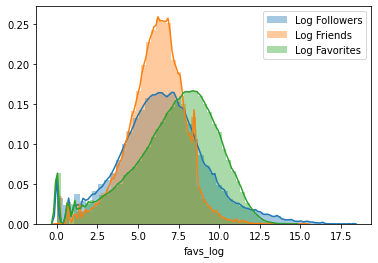

In [6]:
graphs = master_df.copy()
graphs['favs_log'] = np.log(graphs.favourites_count+1)
graphs['retweets_log'] = np.log(graphs.retweet_count+1)
graphs['followers_log'] = np.log(graphs.followers_count+1)
graphs['friends_log'] = np.log(graphs.friends_count+1)

sns.distplot(graphs['followers_log'], label = 'Log Followers')
sns.distplot(graphs['friends_log'], label = 'Log Friends')
sns.distplot(graphs['favs_log'], label = 'Log Favorites')

plt.legend()
plt.show()

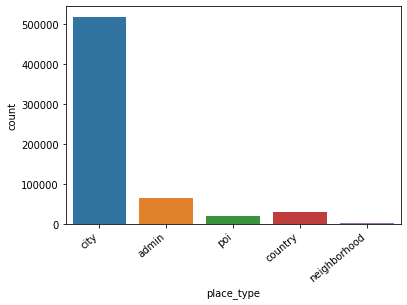

In [7]:
ax = sns.countplot(x="place_type", data = graphs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [8]:
with pd.option_context('display.max_colwidth', 500):
  print(graphs.sort_values(['favs_log'], ascending = [False]).head(20)['text'])

806504                                                                               My prayers go out all these people's families &amp; many more who have lost loved ones during #COVIDー19 #CoronavirusPandemic this is not right we shouldn't have to lose people at all!!! 🙏😭 https://t.co/5661mAYMD4
544243                                                                                                         So my cat is passed out in the rocking chair right next to me like it's unbelievable how he can sleep through this #CoronavirusPandemic man do I wish I was him right now!!! 🐱🥺🤯 #COVIDー19
805461    793 people have passed away in Italy it's time we in America learn from this  &amp; #StayAtHome #SocialDistancing cause this should not be happening at all it's time to stop being reckless &amp; putting others at risk!! #COVIDー19 #Coronavirus #CoronavirusPandemic https://t.co/4HOUh3vtj6
545712                                                                                                    

In [9]:
with pd.option_context('display.max_colwidth', 500):
  print(graphs.sort_values(['retweets_log'], ascending = [False]).head(20)['text'])

792479                                                                                                                                                                                                Sicily has figured out this whole self-isolation thing.\n\n#COVID19 #CoronavirusPandemic \n\nhttps://t.co/93whPVtQcR
696083              This is the face of someone who just spent 9 hours in personal protective equipment moving critically ill Covid19 patients around London.\n\nI feel broken - and we are only at the start. I am begging people, please please do social distancing and self isolation #covid19 https://t.co/hs0RQdvsn3
102891                                                                                                     서로 배려하는 마음으로 #COVID19 를 함께 극복하자는 방탄소년단의 응원 영상을 확인하세요!\n\n손흥민 선수, 응원을 이어주세요!\n\nhttps://t.co/FYtSkDvwjs\n\n#StayConnected #StayStrong_ARMY #힘내세요_아미 #힘내라_대한민국 #힘내라_대구경북 #우리의응원을이어주세요 #BTSLoveMyself #ENDviolence
100892                                                 

In [0]:
#graphs.loc[:,('created_at','account_created_at')] = graphs.loc[:,('created_at','account_created_at')].apply(pd.to_datetime, format = '%Y-%m-%dT%H:%M:%SZ')
#graphs['tweet_dayofweek'] = graphs['created_at'].apply(lambda x: x.weekday() + 1)
#ax = sns.countplot(x="tweet_dayofweek", data = graphs )
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#plt.show()

#graphs['tweet_date'] = graphs['created_at'].apply(lambda x: x.date())
#graphs['tweet_date'] = pd.DatetimeIndex(graphs['tweet_date']).day.astype(int) - 8

#sns.lineplot(x="created_at", y="", data=df)
#plt.xticks(rotation=15)
#plt.title('seaborn-matplotlib example')
#plt.show()

We examine how many NaN values there are in certain columns, such as whether a tweet is a reply to someone else's and whether the user disclosed their geographic location.

In [0]:
print(master_df['reply_to_status_id'].isna().sum())
print(master_df['reply_to_user_id'].isna().sum())
print(master_df['reply_to_screen_name'].isna().sum())
print(master_df['country_code'].isna().sum())
print(master_df['place_full_name'].isna().sum())
print(master_df['place_type'].isna().sum())
print(master_df.shape)

10500549
10181319
10181319
11254897
11252834
11252834
(11887394, 21)


In [10]:
#Culling dataset to more reasonable analytical size.

master_df = master_df[(master_df['followers_count'] + master_df['friends_count'] > 1000)]
master_df = master_df.loc[master_df['lang'] == 'en']
master_df = master_df.drop(['lang'], axis = 1)
master_df.shape

(3843640, 20)

In [11]:
sample_df = master_df.dropna(subset = ['place_full_name']).copy()
sample_df.shape

(230650, 20)

**Feature Extraction**

We extract relevant time features from the data, such as account age, tweet day of week, tweet date, etc.

In [12]:
sample_df.loc[:,('created_at','account_created_at')] = sample_df.loc[:,('created_at','account_created_at')].apply(pd.to_datetime, format = '%Y-%m-%dT%H:%M:%SZ')
sample_df['tweet_dayofweek'] = sample_df['created_at'].apply(lambda x: x.weekday() + 1)
sample_df['tweet_date'] = sample_df['created_at'].apply(lambda x: x.date())
sample_df['tweet_date'] = pd.DatetimeIndex(sample_df['tweet_date']).day.astype(int) - 8
sample_df['account_age_days'] = sample_df['created_at'].sub(sample_df['account_created_at'], axis = 0)
sample_df['account_age_days'] = (sample_df['account_age_days'] / np.timedelta64(1, 'D')).astype(int)
sample_df.head(5)

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_created_at,verified,tweet_dayofweek,tweet_date,account_age_days
75,1236805825685008385,3312730877,2020-03-09 00:07:42,CinfullyMe,@jameshamblin PRIORITIES BABY!! 😱#CoronavirusO...,Twitter for iPhone,1.236782e+18,332993870.0,jameshamblin,False,False,9522,0,US,"Manhattan, NY",city,268,778,2015-06-08 03:30:10,False,1,1,1735
228,1236810878600777728,75375410,2020-03-09 00:27:46,elander777,@JeremyKonyndyk @iluvMarthasVY @ScottGottliebM...,Twitter for Android,1.236704e+18,398172747.0,JeremyKonyndyk,False,False,3845,1,US,"Laurel, VA",city,1123,1135,2009-09-18 20:20:29,False,1,1,3824
328,1236813533876080640,2595877058,2020-03-09 00:38:20,Julesbee7,Practical advice regarding #COVIDー19 here 👇🏻\n...,Twitter for iPhone,NaN,NaN,NaN,False,False,38766,0,AU,"Melbourne, Victoria",city,708,660,2014-06-30 05:58:46,False,1,1,2078
354,1236814626517467136,40922465,2020-03-09 00:42:40,jenpbradley,Thank you @LaurenNews3LV for speaking with @Pu...,Twitter for iPhone,NaN,NaN,NaN,False,False,29241,1,US,"Las Vegas, NV",city,7598,8350,2009-05-18 17:38:36,False,1,1,3947
413,1236816506069155840,1229759196180230150,2020-03-09 00:50:08,lostly_y,OIL PRICES TANK TO 1991 prices\n\n—— .96 cent ...,Twitter for iPhone,NaN,NaN,NaN,True,False,861,0,US,"The Colony, TX",city,385,991,2020-02-18 13:27:13,False,1,1,19


Hourly data (whether a tweet was sent at 3PM vs. 3AM) was difficult, since from 1-24, there are strange relationships.

For example, 1 is only one hour away from '24' even though it is numerically closer to 5. To address this cyclical relation, I used two features (cos and sin) to smooth this out.

In [0]:
#http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

sample_df['tweet_hour'] = sample_df['created_at'].apply(lambda x: x.hour + 1)
sample_df['tweet_hour_cos'] = np.sin(sample_df.tweet_hour*(2. * np.pi/24))
sample_df['tweet_hour_sin'] = np.cos(sample_df.tweet_hour*(2. * np.pi/24))

Given that we do not have access to total impressions or reach, we calculate Engagement Rate for each post via the following:
(Favorites Count + Retweet Count) / (Total Followers + Total Friends)

We also calculate total_engagement, what we hope to be able to predict as favorites count + retweet count.

In [0]:
sample_df['is_reply'] = sample_df['reply_to_status_id'].fillna(0)
sample_df['is_reply'] = sample_df['is_reply'].apply(lambda x: False if x == 0 else True)
sample_df['engagement_rate'] = (sample_df['favourites_count'] + sample_df['retweet_count'])/(sample_df['followers_count']+sample_df['friends_count'])
sample_df['total_engagement'] = sample_df['favourites_count'] + sample_df['retweet_count']
sample_df['total_engagement_log'] = np.log(sample_df.total_engagement+1)

**Further EDA on Subset of Data**

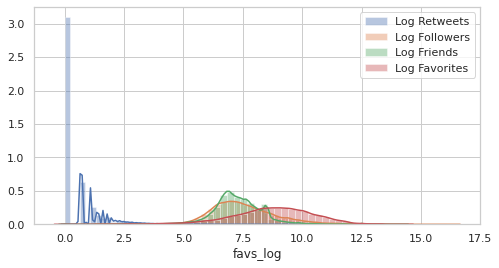

In [43]:
sample_df = sample_df.copy()
sample_df['favs_log'] = np.log(sample_df.favourites_count+1)
sample_df['retweets_log'] = np.log(sample_df.retweet_count+1)
sample_df['followers_log'] = np.log(sample_df.followers_count+1)
sample_df['friends_log'] = np.log(sample_df.friends_count+1)

sns.distplot(sample_df['retweets_log'], label = 'Log Retweets')
sns.distplot(sample_df['followers_log'], label = 'Log Followers')
sns.distplot(sample_df['friends_log'], label = 'Log Friends')
sns.distplot(sample_df['favs_log'], label = 'Log Favorites')

plt.legend()
plt.show()

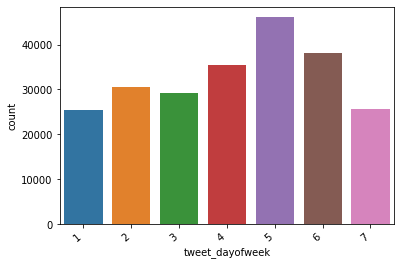

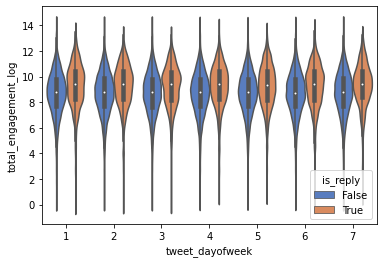

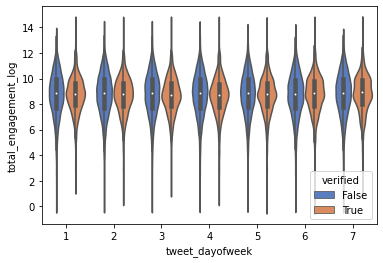

In [16]:
ax = sns.countplot(x="tweet_dayofweek", data = sample_df )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

ax = sns.violinplot(x="tweet_dayofweek", y="total_engagement_log", hue="is_reply",
                    data=sample_df, palette="muted")
plt.show()

ax = sns.violinplot(x="tweet_dayofweek", y="total_engagement_log", hue="verified",
                    data=sample_df, palette="muted")
plt.show()

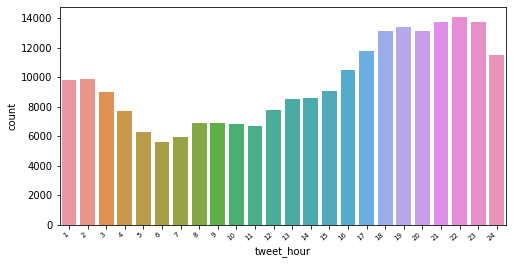

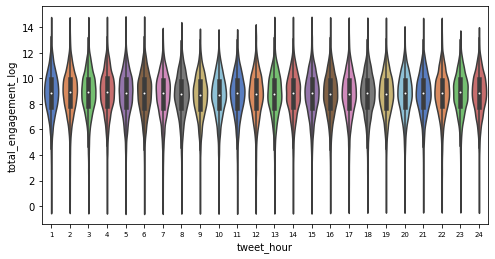

In [116]:
ax = sns.countplot(x="tweet_hour", data = sample_df )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

ax = sns.violinplot(x="tweet_hour", y="total_engagement_log",
                    data=sample_df, palette="muted")
plt.show()

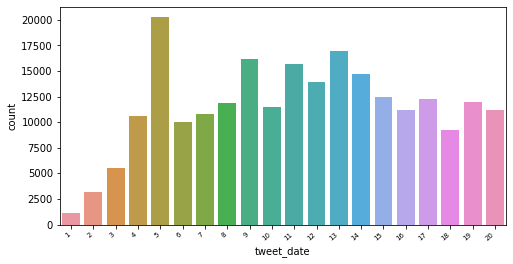

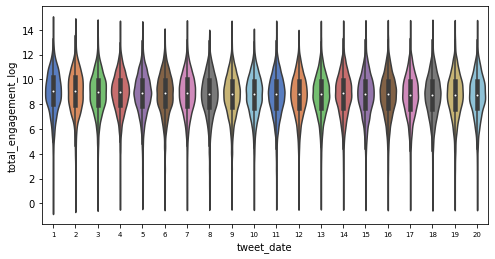

In [117]:
ax = sns.countplot(x="tweet_date", data = sample_df )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

ax = sns.violinplot(x="tweet_date", y="total_engagement_log",
                    data=sample_df, palette="muted")
plt.show()

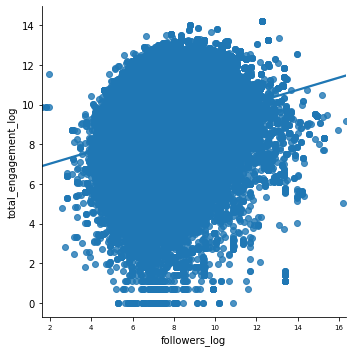

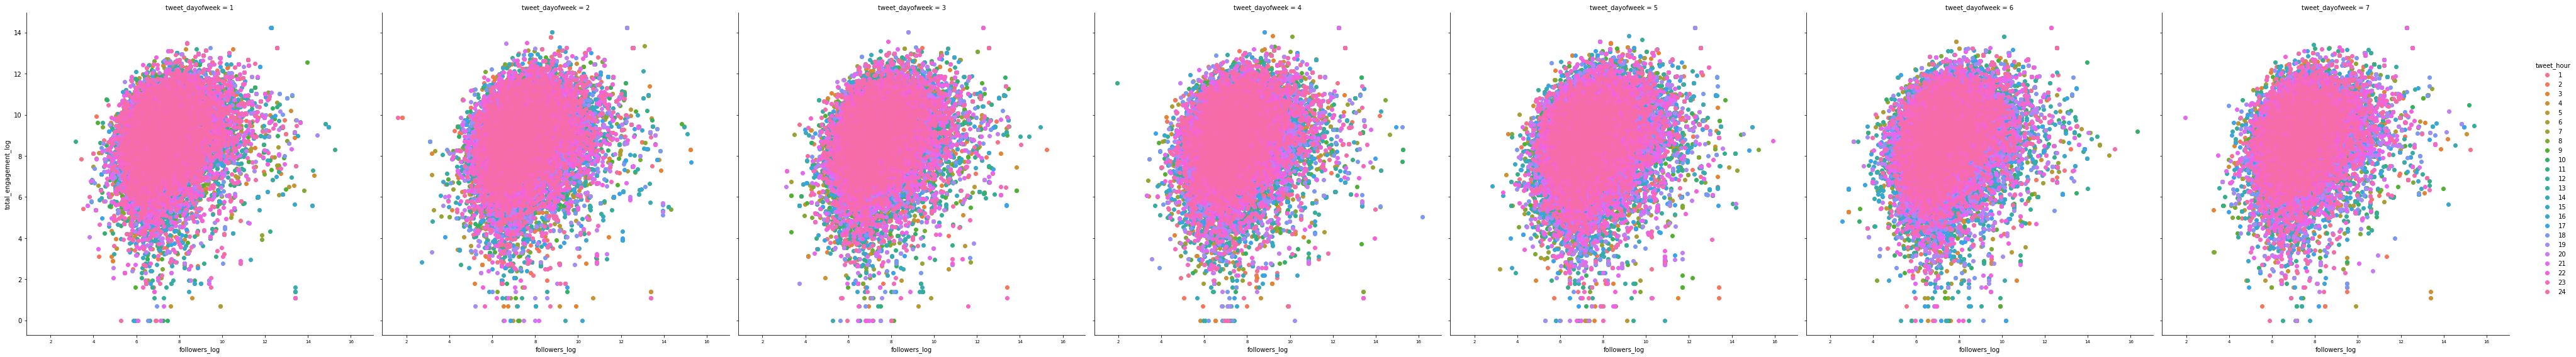

In [118]:
ax = sns.lmplot(x="followers_log", y="total_engagement_log", fit_reg = True,
                    data=sample_df, palette="muted")
plt.show()

g = sns.FacetGrid(sample_df, col = 'tweet_dayofweek', hue = 'tweet_hour', height = 8, aspect =1)
g.map(plt.scatter, 'followers_log','total_engagement_log')
g.add_legend()

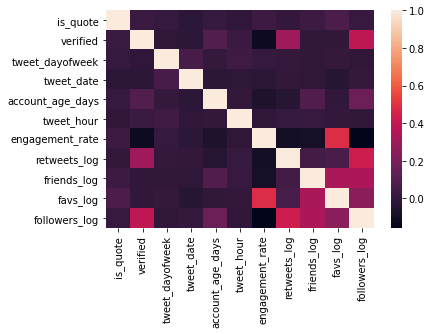

In [23]:
sample_df.head(2)
correlations = sample_df[['is_quote', 'verified', 'tweet_dayofweek','tweet_date', 'account_age_days','tweet_hour', 'engagement_rate', 'retweets_log', 'friends_log', 
                          'favs_log', 'followers_log']]
corr = correlations.corr()
sns.heatmap(corr)


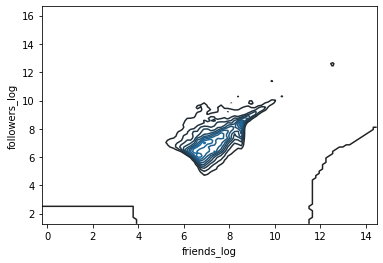

In [18]:
sns.kdeplot(sample_df.friends_log, sample_df.followers_log)

**Twitter Sentiment Analysis**

Feature extraction and Bag of Words (BoW)

In [0]:
import string
def cleantext(text):
  return ''.join([i if ord(i) < 128 else '' for i in text])

sample_df['cleantext'] = sample_df['text'].apply(cleantext)
sample_df['cleantext'] = sample_df['cleantext'].apply(lambda x: x.lower())
sample_df['cleantext'] = sample_df['cleantext'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
sample_df['cleantext'] = sample_df['cleantext'].apply(lambda x: x.replace('\n',''))
sample_df['cleantext'] = sample_df['cleantext'].apply(lambda x: x.replace('amp',''))

In [25]:
sample_df['cleantext_list'] = sample_df['cleantext'].str.split(' ')
sample_df.head(10)

import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

def remove_words(data, list):
  output = [word for word in data if word not in list]
  return output

sample_df['cleaned'] = sample_df['cleantext_list'].apply(lambda x: remove_words(x, stopword))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
sample_df['cleaned'] = sample_df['cleaned'].apply(lambda x: ' '.join(x))
text_array = sample_df['cleaned'].str.split(' ', expand = True).stack().value_counts()
sample_df['cleaned_list'] = sample_df['cleaned'].str.split(' ')


dic = {'word': text_array.index, 'frequency': text_array}
all_words = pd.DataFrame(data = dic)
all_words = all_words.dropna(axis = 0, how = 'any')

#Remove all words appearing less than 20 times
all_words['frequency'] = all_words['frequency'][all_words['frequency'] > 20]
print(all_words.shape)



(434054, 2)


Notes:
- what features work together best --> if its random forest, try not using length and see if it makes it better vs worse
- holdout some features
- PCA 
- one hot encoding not needed, use 1, 2, 3, 4 for dates/day of week etc.
- friend + follower count for EDA --> use as a feature
- correlation matrix
- bagofwords

Modeling
- Linear regression
- justifying the model usage

- graphics for EDA
- 

In [27]:
import urllib.request
positive = urllib.request.urlopen('https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/08a269765a6b185d5f3dd522c876043ba9628715/data/opinion-lexicon-English/positive-words.txt').read()
negative = urllib.request.urlopen('https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/08a269765a6b185d5f3dd522c876043ba9628715/data/opinion-lexicon-English/negative-words.txt').read()

pos_string = positive[1540:].decode('utf-8')
neg_string = negative[1541:].decode('utf-8', 'ignore')
pos = pos_string.split('\n')
neg = neg_string.split('\n')
print(pos)
print(neg)

['abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously', 'advantages', 'adventuresome', 'adventurous', 'advocate', 'advocated', 'advocates', 'affability', 'affable', 'affably', 'affectation', 'affection', 'affectionate', 'affinity', 'affirm', 'affirmation', 'affirmative', 'affluence', 'affluent', 'afford', 'affordable', 'affordably', 'afordable', 'agile', 'agilely', 'agility', 'agreeable', 'agreeabl

In [0]:

all_words['frequency'] = all_words['frequency'].dropna().apply(lambda x: int(x))
all_words['word'].replace('', np.nan, inplace=True)
all_words.dropna(subset=['word'], inplace=True)

pos_tuples = all_words[all_words.word.isin(pos)].to_records(index = False)
neg_tuples = all_words[all_words.word.isin(neg)].to_records(index = False)
poscloud = dict(list(pos_tuples))
negcloud = dict(list(neg_tuples))

#Remove IDs used to collect this dataset
removed_ids = all_words.drop(['covid19', 'coronavirus','coronaviruspandemic','coronavirusoutbreak'])

tuples = removed_ids.head(50).to_records(index = False)
wordcloud = list(tuples)
select = list(range(1,50))
selected = dict([wordcloud[i] for i in select])


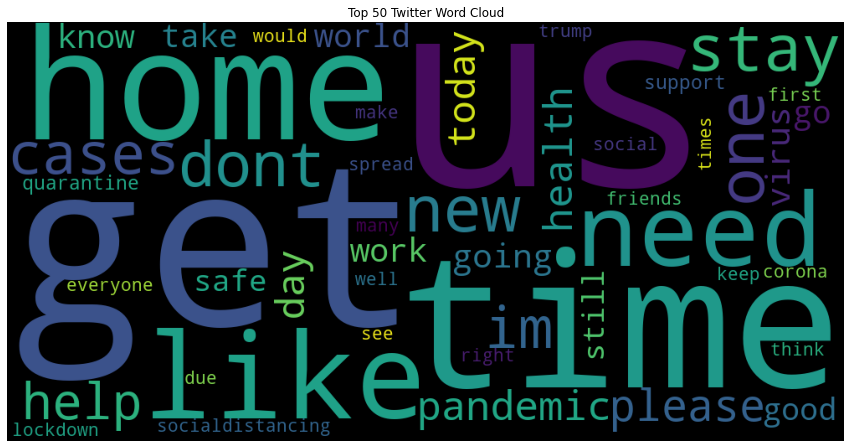

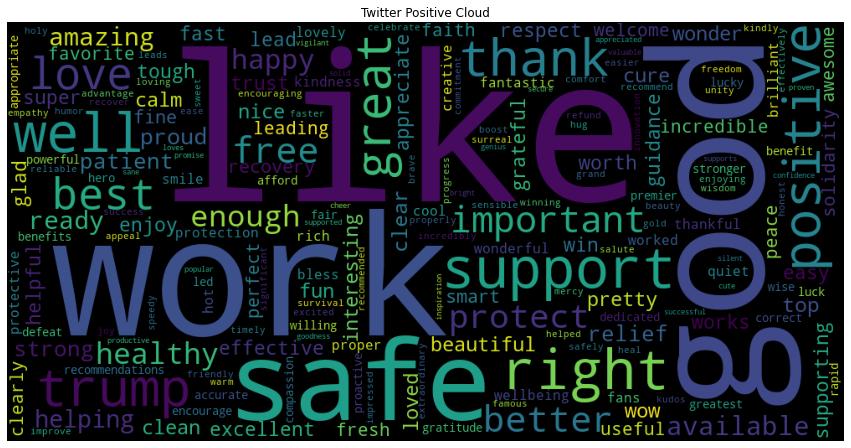

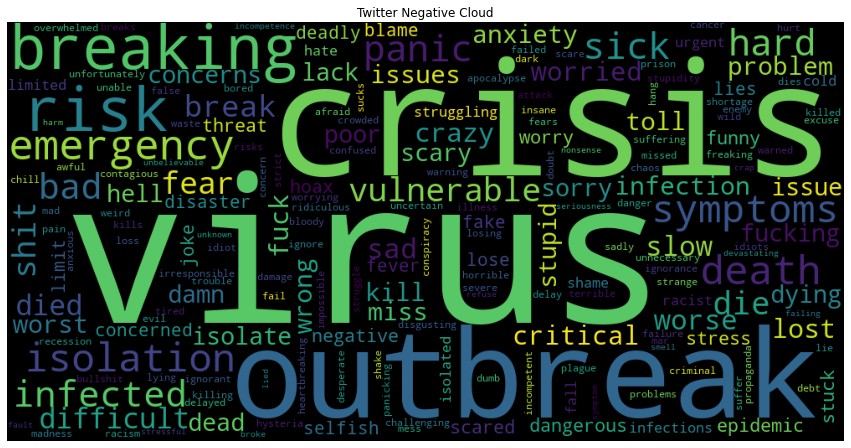

In [29]:
from wordcloud import WordCloud
from collections import Counter

cloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(selected)

plt.figure(figsize=(15,8))
plt.title('Top 50 Twitter Word Cloud')
plt.imshow(cloud)
plt.axis('off')
plt.show()
plt.close()

cloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(poscloud)

plt.figure(figsize=(15,8))
plt.title('Twitter Positive Cloud')
plt.imshow(cloud)
plt.axis('off')
plt.show()
plt.close()

cloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(negcloud)

plt.figure(figsize=(15,8))
plt.title('Twitter Negative Cloud')
plt.imshow(cloud)
plt.axis('off')
plt.show()
plt.close()

**Zipf's Law**

Text(0.5, 1.0, 'Top 500 words in tweets')

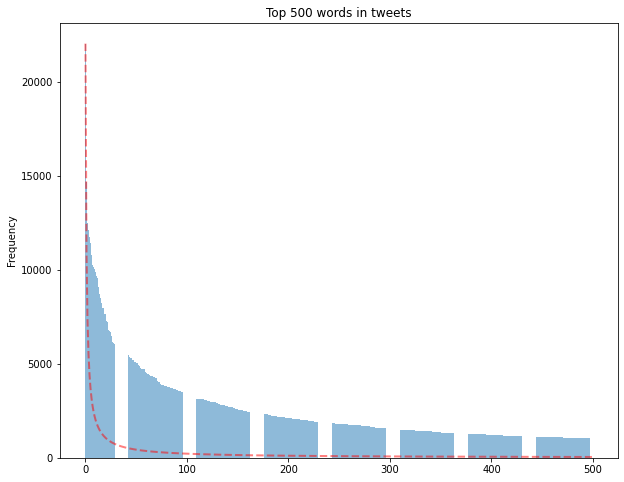

In [30]:
y_axis = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [removed_ids.sort_values(by='frequency', ascending=False)['frequency'][0]/(i+1)**s for i in y_axis]
plt.bar(y_axis, removed_ids.sort_values(by='frequency', ascending=False)['frequency'][:500], align='center', alpha=0.5)
plt.plot(y_axis, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 words in tweets')

**Positive and Negative Sentiments**

In [0]:
#reply_search_df = master_df.copy()
#reply_search_df.dropna(subset = ['reply_to_status_id'], inplace = True)
#reply_search_df.head(10)
#Opportunity to go further down the reply thread chain for further info if time allows
#reply_search_df = reply_search_df[['status_id', 'favourites_count','retweet_count','followers_count','friends_count']]

#check_df = pd.merge(master_df, reply_search_df, how = 'left', left_on = 'reply_to_status_id', right_on = 'status_id', suffixes = ('_orig', '_reply'))
#print(check_df.info())
#print(check_df.head(10))

In [31]:
def clean_pos(list):
  output = [word for word in list if word in pos]
  return output

def clean_neg(list):
  output = [word for word in list if word in neg]
  return output

sample_df['positives'] = sample_df['cleaned_list'].apply(lambda x: clean_pos(x))
sample_df['negatives'] = sample_df['cleaned_list'].apply(lambda x: clean_neg(x))
sample_df.head(5)

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_created_at,verified,tweet_dayofweek,tweet_date,account_age_days,tweet_hour,tweet_hour_cos,tweet_hour_sin,is_reply,engagement_rate,total_engagement,total_engagement_log,favs_log,retweets_log,followers_log,friends_log,cleantext,cleantext_list,cleaned,cleaned_list,positives,negatives
75,1236805825685008385,3312730877,2020-03-09 00:07:42,CinfullyMe,@jameshamblin PRIORITIES BABY!! 😱#CoronavirusO...,Twitter for iPhone,1.236782e+18,332993870.0,jameshamblin,False,False,9522,0,US,"Manhattan, NY",city,268,778,2015-06-08 03:30:10,False,1,1,1735,1,0.258819,0.965926,True,9.103250,9522,9.161465,9.161465,0.000000,5.594711,6.658011,jameshamblin priorities baby coronavirusoutbreak,"[jameshamblin, priorities, baby, coronavirusou...",jameshamblin priorities baby coronavirusoutbreak,"[jameshamblin, priorities, baby, coronavirusou...",[],[]
228,1236810878600777728,75375410,2020-03-09 00:27:46,elander777,@JeremyKonyndyk @iluvMarthasVY @ScottGottliebM...,Twitter for Android,1.236704e+18,398172747.0,JeremyKonyndyk,False,False,3845,1,US,"Laurel, VA",city,1123,1135,2009-09-18 20:20:29,False,1,1,3824,1,0.258819,0.965926,True,1.703277,3846,8.255049,8.254789,0.693147,7.024649,7.035269,jeremykonyndyk iluvmarthasvy scottgottliebmd i...,"[jeremykonyndyk, iluvmarthasvy, scottgottliebm...",jeremykonyndyk iluvmarthasvy scottgottliebmd t...,"[jeremykonyndyk, iluvmarthasvy, scottgottliebm...",[],[]
328,1236813533876080640,2595877058,2020-03-09 00:38:20,Julesbee7,Practical advice regarding #COVIDー19 here 👇🏻\n...,Twitter for iPhone,NaN,NaN,NaN,False,False,38766,0,AU,"Melbourne, Victoria",city,708,660,2014-06-30 05:58:46,False,1,1,2078,1,0.258819,0.965926,False,28.337719,38766,10.565325,10.565325,0.000000,6.563856,6.493754,practical advice regarding covid19 here corona...,"[practical, advice, regarding, covid19, here, ...",practical advice regarding covid19 coronavirus...,"[practical, advice, regarding, covid19, corona...",[],[]
354,1236814626517467136,40922465,2020-03-09 00:42:40,jenpbradley,Thank you @LaurenNews3LV for speaking with @Pu...,Twitter for iPhone,NaN,NaN,NaN,False,False,29241,1,US,"Las Vegas, NV",city,7598,8350,2009-05-18 17:38:36,False,1,1,3947,1,0.258819,0.965926,False,1.833584,29242,10.283396,10.283361,0.693147,8.935772,9.030137,thank you laurennews3lv for speaking with publ...,"[thank, you, laurennews3lv, for, speaking, wit...",thank laurennews3lv speaking publichealthrx ch...,"[thank, laurennews3lv, speaking, publichealthr...",[thank],[]
413,1236816506069155840,1229759196180230150,2020-03-09 00:50:08,lostly_y,OIL PRICES TANK TO 1991 prices\n\n—— .96 cent ...,Twitter for iPhone,NaN,NaN,NaN,True,False,861,0,US,"The Colony, TX",city,385,991,2020-02-18 13:27:13,False,1,1,19,1,0.258819,0.965926,False,0.625727,861,6.759255,6.759255,0.000000,5.955837,6.899723,oil prices tank to 1991 prices 96 cent gas ap...,"[oil, prices, tank, to, 1991, prices, 96, cent...",oil prices tank 1991 prices 96 cent gas apoca...,"[oil, prices, tank, 1991, prices, 96, cent, ga...","[, , , , ]","[tank, , apocalypse, , , , ]"


In [32]:
sample_df['positives'] = sample_df['positives'].apply(lambda x: len([word for word in x if word.strip()]))
sample_df['negatives'] = sample_df['negatives'].apply(lambda x: len([word for word in x if word.strip()]))
sample_df.head(10)

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_created_at,verified,tweet_dayofweek,tweet_date,account_age_days,tweet_hour,tweet_hour_cos,tweet_hour_sin,is_reply,engagement_rate,total_engagement,total_engagement_log,favs_log,retweets_log,followers_log,friends_log,cleantext,cleantext_list,cleaned,cleaned_list,positives,negatives
75,1236805825685008385,3312730877,2020-03-09 00:07:42,CinfullyMe,@jameshamblin PRIORITIES BABY!! 😱#CoronavirusO...,Twitter for iPhone,1.236782e+18,3.329939e+08,jameshamblin,False,False,9522,0,US,"Manhattan, NY",city,268,778,2015-06-08 03:30:10,False,1,1,1735,1,0.258819,0.965926,True,9.103250,9522,9.161465,9.161465,0.000000,5.594711,6.658011,jameshamblin priorities baby coronavirusoutbreak,"[jameshamblin, priorities, baby, coronavirusou...",jameshamblin priorities baby coronavirusoutbreak,"[jameshamblin, priorities, baby, coronavirusou...",0,0
228,1236810878600777728,75375410,2020-03-09 00:27:46,elander777,@JeremyKonyndyk @iluvMarthasVY @ScottGottliebM...,Twitter for Android,1.236704e+18,3.981727e+08,JeremyKonyndyk,False,False,3845,1,US,"Laurel, VA",city,1123,1135,2009-09-18 20:20:29,False,1,1,3824,1,0.258819,0.965926,True,1.703277,3846,8.255049,8.254789,0.693147,7.024649,7.035269,jeremykonyndyk iluvmarthasvy scottgottliebmd i...,"[jeremykonyndyk, iluvmarthasvy, scottgottliebm...",jeremykonyndyk iluvmarthasvy scottgottliebmd t...,"[jeremykonyndyk, iluvmarthasvy, scottgottliebm...",0,0
328,1236813533876080640,2595877058,2020-03-09 00:38:20,Julesbee7,Practical advice regarding #COVIDー19 here 👇🏻\n...,Twitter for iPhone,NaN,NaN,NaN,False,False,38766,0,AU,"Melbourne, Victoria",city,708,660,2014-06-30 05:58:46,False,1,1,2078,1,0.258819,0.965926,False,28.337719,38766,10.565325,10.565325,0.000000,6.563856,6.493754,practical advice regarding covid19 here corona...,"[practical, advice, regarding, covid19, here, ...",practical advice regarding covid19 coronavirus...,"[practical, advice, regarding, covid19, corona...",0,0
354,1236814626517467136,40922465,2020-03-09 00:42:40,jenpbradley,Thank you @LaurenNews3LV for speaking with @Pu...,Twitter for iPhone,NaN,NaN,NaN,False,False,29241,1,US,"Las Vegas, NV",city,7598,8350,2009-05-18 17:38:36,False,1,1,3947,1,0.258819,0.965926,False,1.833584,29242,10.283396,10.283361,0.693147,8.935772,9.030137,thank you laurennews3lv for speaking with publ...,"[thank, you, laurennews3lv, for, speaking, wit...",thank laurennews3lv speaking publichealthrx ch...,"[thank, laurennews3lv, speaking, publichealthr...",1,0
413,1236816506069155840,1229759196180230150,2020-03-09 00:50:08,lostly_y,OIL PRICES TANK TO 1991 prices\n\n—— .96 cent ...,Twitter for iPhone,NaN,NaN,NaN,True,False,861,0,US,"The Colony, TX",city,385,991,2020-02-18 13:27:13,False,1,1,19,1,0.258819,0.965926,False,0.625727,861,6.759255,6.759255,0.000000,5.955837,6.899723,oil prices tank to 1991 prices 96 cent gas ap...,"[oil, prices, tank, to, 1991, prices, 96, cent...",oil prices tank 1991 prices 96 cent gas apoca...,"[oil, prices, tank, 1991, prices, 96, cent, ga...",0,2
421,1236816686529085443,18944403,2020-03-09 00:50:51,nvancleve,.@drjodyrich is my colleague @BrownUniversity....,Twitter for iPhone,NaN,NaN,NaN,True,False,27825,0,US,"Providence, RI",city,7462,2346,2009-01-13 17:11:41,True,1,1,4072,1,0.258819,0.965926,False,2.836970,27825,10.233726,10.233726,0.000000,8.917713,7.760893,drjodyrich is my colleague brownuniversity th...,"[drjodyrich, is, my, colleague, brownuniversit...",drjodyrich colleague brownuniversity public h...,"[drjodyrich, colleague, brownuniversity, , pub...",0,2
452,1236817541923659777,274854594,2020-03-09 00:54:15,toppy999,Oh @realDonaldTrump you really are a simpleton...,Twitter for iPhone,NaN,NaN,NaN,True,False,675,0,AU,"Canberra, Australian Capital Territory",city,249,1626,2011-03-31 04:30:07,False,1,1,3265,1,0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


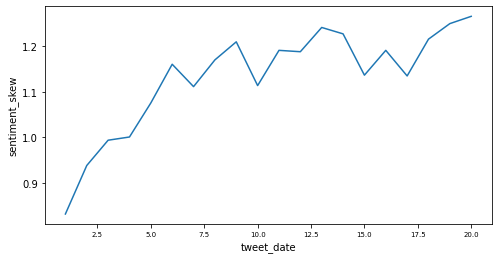

1.1588181789668475


In [33]:
graph_df = sample_df.groupby(['tweet_date'])['positives','negatives'].sum().reset_index()
graph_df['sentiment_skew'] = graph_df['positives'] / graph_df['negatives']

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["xtick.labelsize"] = 7
ax = sns.lineplot(x = 'tweet_date', y = 'sentiment_skew', data = graph_df)
plt.show()

negative_sentiment = sample_df['negatives'].sum()
positive_sentiment = sample_df['positives'].sum()
skew = positive_sentiment / negative_sentiment
print(skew)

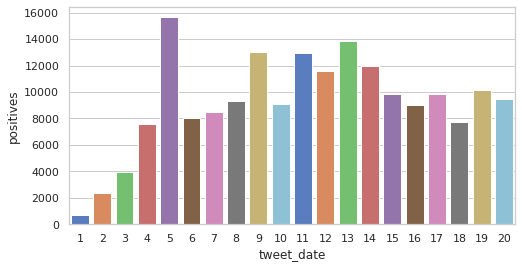

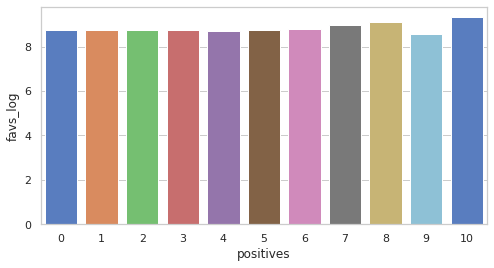

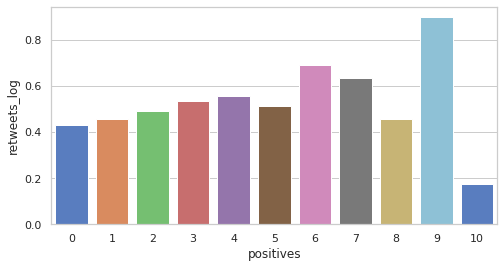

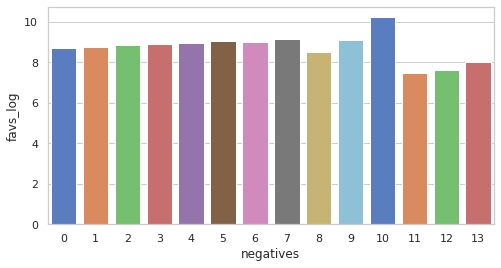

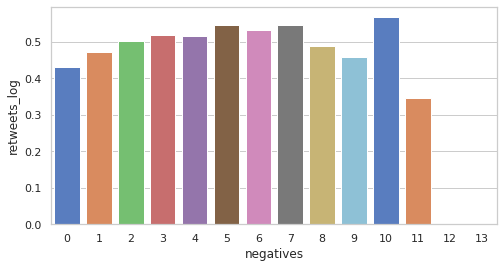

In [47]:
graphs = sample_df.groupby('tweet_date').sum()
graphs.reset_index(inplace=True)
ax = sns.barplot(x="tweet_date", y="positives",
                    data=graphs, palette="muted")
plt.show()

graphs = sample_df.groupby('positives').mean()
graphs.reset_index(inplace=True)
ax = sns.barplot(x="positives", y="favs_log",
                    data=graphs, palette="muted")
plt.show()

ax = sns.barplot(x="positives", y="retweets_log",
                    data=graphs, palette="muted")
plt.show()

graphs2 = sample_df.groupby('negatives').mean()
graphs2.reset_index(inplace=True)
ax = sns.barplot(x="negatives", y="favs_log",
                    data=graphs2, palette="muted")
plt.show()
ax = sns.barplot(x="negatives", y="retweets_log",
                    data=graphs2, palette="muted")
plt.show()



**Hashtag and Mention**

(81560, 2)


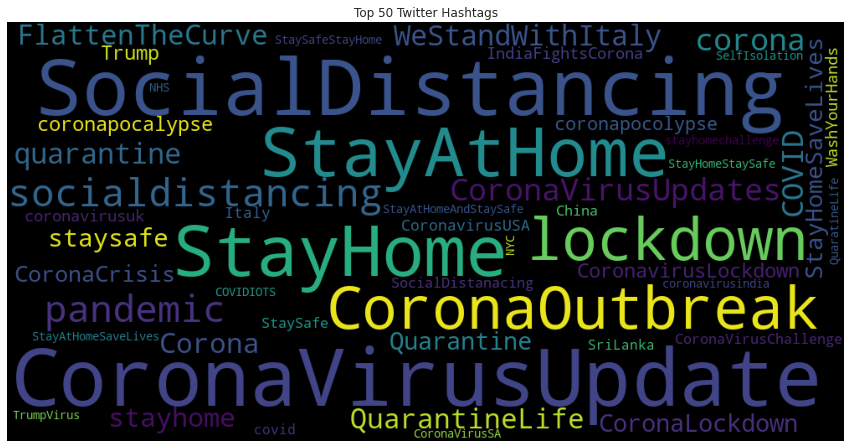

In [48]:
sample_df['hashtags'] = sample_df['text'].apply(lambda x: [word[1:] for word in x.split() if word[0] == '#' and word[1:].isalpha()])
sample_df['hashtag_num'] = sample_df['hashtags'].str.len()

sample_df['hashtags'] = sample_df['hashtags'].apply(lambda x: ' '.join(x))
hashtag_array = sample_df['hashtags'].str.split(' ', expand = True).stack().value_counts()

hash_dic = {'hashtag': hashtag_array.index, 'frequency': hashtag_array}
all_tags = pd.DataFrame(data = hash_dic)
all_tags = all_tags.dropna(axis = 0, how = 'any')
#Remove all hashtags appearing less than 20 times
all_tags['frequency'] = all_tags['frequency'][all_tags['frequency'] > 20]
print(all_tags.shape)
all_tags['frequency'] = all_tags['frequency'].dropna().apply(lambda x: int(x))
all_tags['hashtag'].replace('', np.nan, inplace=True)
all_tags.dropna(subset=['hashtag'], inplace=True)

#Remove hashtags used to compile the raw data
removed_ids = all_tags.drop(['coronavirus','coronaviruspandemic','coronavirusoutbreak','Coronavirus','CoronaVirus', 'CoronavirusPandemic'
,'CoronavirusOutbreak'])

tuples = removed_ids.head(50).to_records(index = False)
wordcloud = list(tuples)
select = list(range(0,50))
selected = dict([wordcloud[i] for i in select])

cloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(selected)
plt.figure(figsize=(15,8))
plt.title('Top 50 Twitter Hashtags')
plt.imshow(cloud)
plt.axis('off')
plt.show()
plt.close()

(49191, 2)


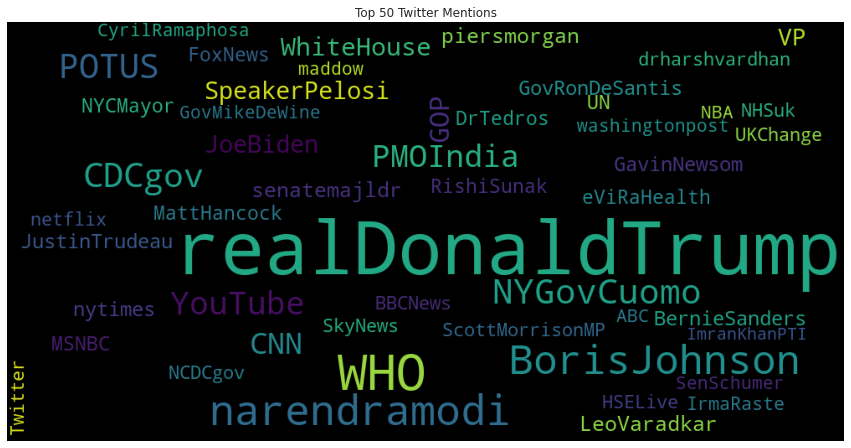

In [49]:
sample_df['mentions'] = sample_df['text'].apply(lambda x: [word[1:] for word in x.split() if word[0] == '@' and word[1:].isalpha()])
sample_df['mentions_num'] = sample_df['mentions'].str.len()

sample_df['mentions'] = sample_df['mentions'].apply(lambda x: ' '.join(x))
mentions_array = sample_df['mentions'].str.split(' ', expand = True).stack().value_counts()
#sample_df['cleaned_list'] = sample_df['cleaned'].str.split(' ')


dic = {'tag': mentions_array.index, 'frequency': mentions_array}
all_tags = pd.DataFrame(data = dic)
all_tags = all_tags.dropna(axis = 0, how = 'any')
#Remove all hashtags appearing less than 20 times
all_tags['frequency'] = all_tags['frequency'][all_tags['frequency'] > 20]
print(all_tags.shape)
all_tags['frequency'] = all_tags['frequency'].dropna().apply(lambda x: int(x))
all_tags['tag'].replace('', np.nan, inplace=True)
all_tags.dropna(subset=['tag'], inplace=True)

tuples = all_tags.head(50).to_records(index = False)
wordcloud = list(tuples)
select = list(range(0,50))
selected = dict([wordcloud[i] for i in select])

cloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(selected)
plt.figure(figsize=(15,8))
plt.title('Top 50 Twitter Mentions')
plt.imshow(cloud)
plt.axis('off')
plt.show()
plt.close()

**Additional Text Feature Extraction**

In [54]:
sample_df['characters'] = sample_df['text'].astype(str).map(len)
sample_df['words'] = sample_df['cleantext_list'].str.len()

sample_df.head(5)

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_created_at,verified,tweet_dayofweek,tweet_date,account_age_days,tweet_hour,tweet_hour_cos,tweet_hour_sin,is_reply,engagement_rate,total_engagement,total_engagement_log,favs_log,retweets_log,followers_log,friends_log,cleantext,cleantext_list,cleaned,cleaned_list,positives,negatives,hashtags,hashtag_num,mentions,mentions_num,characters,words
75,1236805825685008385,3312730877,2020-03-09 00:07:42,CinfullyMe,@jameshamblin PRIORITIES BABY!! 😱#CoronavirusO...,Twitter for iPhone,1.236782e+18,332993870.0,jameshamblin,False,False,9522,0,US,"Manhattan, NY",city,268,778,2015-06-08 03:30:10,False,1,1,1735,1,0.258819,0.965926,True,9.103250,9522,9.161465,9.161465,0.000000,5.594711,6.658011,jameshamblin priorities baby coronavirusoutbreak,"[jameshamblin, priorities, baby, coronavirusou...",jameshamblin priorities baby coronavirusoutbreak,"[jameshamblin, priorities, baby, coronavirusou...",0,0,,0,jameshamblin,1,53,4
228,1236810878600777728,75375410,2020-03-09 00:27:46,elander777,@JeremyKonyndyk @iluvMarthasVY @ScottGottliebM...,Twitter for Android,1.236704e+18,398172747.0,JeremyKonyndyk,False,False,3845,1,US,"Laurel, VA",city,1123,1135,2009-09-18 20:20:29,False,1,1,3824,1,0.258819,0.965926,True,1.703277,3846,8.255049,8.254789,0.693147,7.024649,7.035269,jeremykonyndyk iluvmarthasvy scottgottliebmd i...,"[jeremykonyndyk, iluvmarthasvy, scottgottliebm...",jeremykonyndyk iluvmarthasvy scottgottliebmd t...,"[jeremykonyndyk, iluvmarthasvy, scottgottliebm...",0,0,coronavirus CoronavirusOutbreak,2,JeremyKonyndyk iluvMarthasVY ScottGottliebMD,3,146,17
328,1236813533876080640,2595877058,2020-03-09 00:38:20,Julesbee7,Practical advice regarding #COVIDー19 here 👇🏻\n...,Twitter for iPhone,NaN,NaN,NaN,False,False,38766,0,AU,"Melbourne, Victoria",city,708,660,2014-06-30 05:58:46,False,1,1,2078,1,0.258819,0.965926,False,28.337719,38766,10.565325,10.565325,0.000000,6.563856,6.493754,practical advice regarding covid19 here corona...,"[practical, advice, regarding, covid19, here, ...",practical advice regarding covid19 coronavirus...,"[practical, advice, regarding, covid19, corona...",0,0,CoronavirusOutbreak coronavirus,2,,0,136,8
354,1236814626517467136,40922465,2020-03-09 00:42:40,jenpbradley,Thank you @LaurenNews3LV for speaking with @Pu...,Twitter for iPhone,NaN,NaN,NaN,False,False,29241,1,US,"Las Vegas, NV",city,7598,8350,2009-05-18 17:38:36,False,1,1,3947,1,0.258819,0.965926,False,1.833584,29242,10.283396,10.283361,0.693147,8.935772,9.030137,thank you laurennews3lv for speaking with publ...,"[thank, you, laurennews3lv, for, speaking, wit...",thank laurennews3lv speaking publichealthrx ch...,"[thank, laurennews3lv, speaking, publichealthr...",1,0,healthcare medical CDC,3,PublicHealthRx rosemanuhs,2,221,26
413,1236816506069155840,1229759196180230150,2020-03-09 00:50:08,lostly_y,OIL PRICES TANK TO 1991 prices\n\n—— .96 cent ...,Twitter for iPhone,NaN,NaN,NaN,True,False,861,0,US,"The Colony, TX",city,385,991,2020-02-18 13:27:13,False,1,1,19,1,0.258819,0.965926,False,0.625727,861,6.759255,6.759255,0.000000,5.955837,6.899723,oil prices tank to 1991 prices 96 cent gas ap...,"[oil, prices, tank, to, 1991, prices, 96, cent...",oil prices tank 1991 prices 96 cent gas apoca...,"[oil, prices, tank, 1991, prices, 96, cent, ga...",0,2,CoronavirusOutbreak CoronaOutbreak coronavirus...,5,,0,213,23


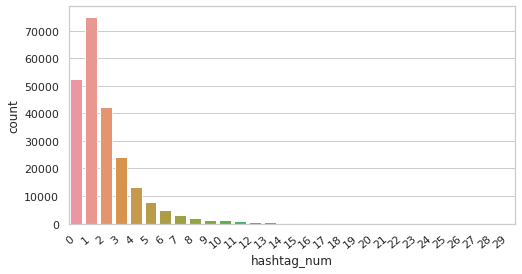

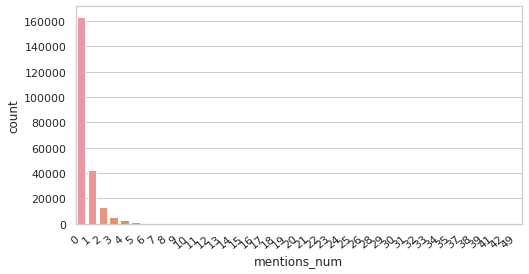

In [62]:
ax = sns.countplot(x="hashtag_num", data = sample_df )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()


ax = sns.countplot(x="mentions_num", data = sample_df )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

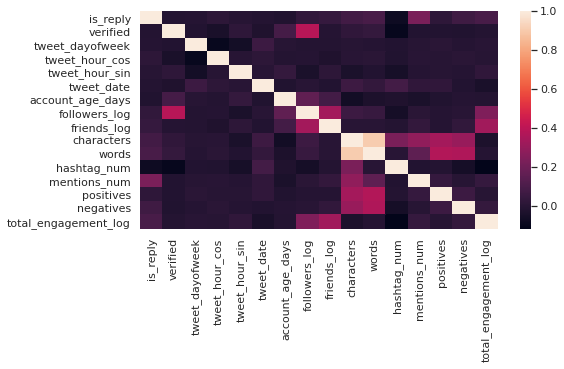

In [65]:
corr_df = sample_df[['source','is_reply','country_code', 'place_type',
                     'verified','tweet_dayofweek','tweet_hour_cos', 'tweet_hour_sin','tweet_date',
                     'account_age_days', 'followers_log', 'friends_log', 'characters', 'words', 'hashtag_num',
                     'mentions_num',
                     'positives','negatives','total_engagement_log']]
corr = corr_df.corr()
sns.heatmap(corr)

**Preparing Dataframe for Model-Building**

In [0]:
def consolidate_small_counts(col, threshold):
  counts = sample_df[col].value_counts()
  misc = counts.index[counts < threshold]
  sample_df.loc[sample_df[col].isin(misc), col] = "Other"

consolidate_small_counts('source', 100)
consolidate_small_counts('country_code', 100)


In [0]:
input_df = sample_df.copy()
input_df = input_df[['status_id', 'source','is_quote','is_retweet','is_reply','country_code', 'place_type',
                     'verified','tweet_dayofweek','tweet_hour_cos', 'tweet_hour_sin','tweet_date',
                     'account_age_days', 'followers_log', 'friends_log', 'characters', 'words', 'hashtag_num',
                     'mentions_num',
                     'positives','negatives','total_engagement_log']]
input_df.set_index('status_id')
input_df.source = input_df.source.astype('category')
input_df.place_type = input_df.place_type.astype('category')
input_df.country_code = input_df.country_code.astype('category')
input_df.tweet_dayofweek = input_df.tweet_dayofweek.astype('category')
input_df = pd.get_dummies(data = input_df, columns = ['source', 'country_code', 'place_type', 'tweet_dayofweek'])

**Models**

Initial Linear Regression

In [67]:
label = input_df['total_engagement_log']
features = input_df.drop(columns = 'total_engagement_log')

features.shape


(230650, 109)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.20)

regr = LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

mse_test = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_test)
median_abs_test = metrics.median_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse_test)
print(rmse)
print(median_abs_test)
print(r2)

2.4979197817816727
1.5804808704257298
0.9809830499358032
0.1600540858475974


**PCA**

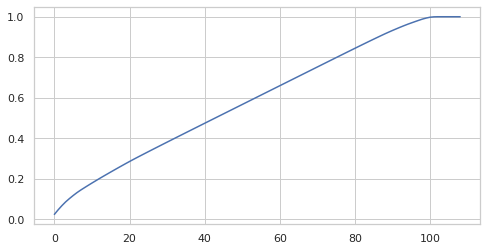

In [69]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(x_train)
pca = PCA(n_components=109)
X2 = pca.fit_transform(X)
np.set_printoptions(suppress=True)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
pc_vs_variance
plt.plot(pc_vs_variance)

In [70]:
pca = PCA(n_components=99)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)
regr = LinearRegression()
regr.fit(x_train, y_train)


y_pred = regr.predict(x_test)

mse_test = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_test)
median_abs_test = metrics.median_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse_test)
print(rmse)
print(median_abs_test)
print(r2)

2.498369610155208
1.5806231714596646
0.9802818661448391
0.1599028273855857


In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 70, num = 3)]
max_depth = [int(x) for x in np.linspace(1, 2, num = 1)]
min_samples_split = [int(x) for x in np.linspace(start = 50, stop = 100, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(start = 50, stop = 100, num = 5)]


max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_depth': [3],
               'min_samples_split': [50],
               'min_samples_leaf': [25]
               }

clf = RandomForestRegressor(n_estimators=100,max_depth=3,min_samples_split=60,min_samples_leaf=30)
#rf_tune = GridSearchCV(estimator = clf, param_grid = random_grid)
clf.fit(x_train, y_train)
#best_params = rf_tune.best_params_
#best_grid = rf_tune.best_estimator_

y_pred = clf.predict(x_test)

mse_test = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_test)
median_abs_test = metrics.median_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse_test)
print(rmse)
print(median_abs_test)
print(r2)

2.5594030584759304
1.5998134448978514
1.0014570074237534
0.139379832244782


In [77]:
y_pred = clf.predict(x_test)

mse_test = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_test)
median_abs_test = metrics.median_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse_test)
print(rmse)
print(median_abs_test)
print(r2)

2.561903054923459
1.6005945941816306
1.0015751761649496
0.1385391880348229


In [72]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

l1r = Lasso()
l2r = Ridge()
netr = ElasticNet()

l1r.fit(x_train, y_train)
y_pred = l1r.predict(x_test)

mse_test = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_test)
median_abs_test = metrics.median_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse_test)
print(rmse)
print(median_abs_test)
print(r2)

2.9673589733376624
1.7226023839927955
1.0927789275221382
0.0022013262168543157


In [73]:
l2r.fit(x_train, y_train)
y_pred = l2r.predict(x_test)

mse_test = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_test)
median_abs_test = metrics.median_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse_test)
print(rmse)
print(median_abs_test)
print(r2)

2.357478508625259
1.5354082547079324
0.9566038220268092
0.20727861020039795


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10831e-36): result may not be accurate.
  overwrite_a=True).T


In [74]:
netr.fit(x_train, y_train)
y_pred = netr.predict(x_test)

mse_test = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_test)
median_abs_test = metrics.median_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse_test)
print(rmse)
print(median_abs_test)
print(r2)

2.8287737626795484
1.6818958834242828
1.057028632379248
0.048801734405785946


{'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 62}
2.616525116838362
1.6175676544856978
1.013126300662731
0.12336358686947635


**Appendix**


---


---



In [0]:
main_df = pd.read_csv('tweet_covid/2020-03-00 Coronavirus Tweets (pre 2020-03-12).CSV')
main_df = main_df[main_df['text'].str.contains("\\$")]
main_df['text'] = main_df['text'].apply(lambda x: [word[1:] for word in x.split() if word[0] == '$' and word[1:].isalpha()])
main_df = main_df[(main_df['text'].str.len() != 0)]
total = 0
print(len(main_df))

In [0]:
for i in range(12,31):
  sample_df = pd.read_csv('tweet_covid/2020-03-' + str(i) + ' Coronavirus Tweets.CSV')
  #tickers = sample_df[sample_df['text'].str.contains("\\$")]
  tickers = sample_df[sample_df['text'].str.contains("\\$")]
  #ex_df = tickers['text'].str.extract('\\$([A-Z])\s+')
  tickers['text'] = tickers['text'].apply(lambda x: [word[1:] for word in x.split() if word[0] == '$' and word[1:].isalpha()])
  tickers = tickers[(tickers['text'].str.len() != 0)]
  #tickers['text'] = 
  main_df = main_df.append(tickers)
  print(len(tickers))
  total = len(tickers) + total
  #print(total)
  #print(ex_df.head())
  #print(tickers.head())
print(main_df.head(30))
print(main_df.info())
print(total)

In [0]:
tickers = sample_df[sample_df['text'].str.contains("Instacart")]
pd.set_option('display.max_columns', None)
#print(tickers)
sample_df.describe()

In [0]:
#%spark add -s my_session1 -l python -u http://ec2-18-206-74-229.compute-1.amazonaws.com:8998